# Smooth gear-shifting illustrations 
These figures appear in the publication 

A. Abudukelimu, T.D.G.A. Mondeel, M. Barberis, H. V. Westerhoff, Learning to read and write in evolution: from static pseudoenzymes and pseudosignalers to dynamic gear shifters, Biochem. Soc. Trans. 45 (2017) 635–652. [doi:10.1042/BST20160281](http://doi.org/10.1042/BST20160281).

In [1]:
import cobra
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SET PLOTTING SETTINGS
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
BIGGEST_SIZE = 28

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# import local functions
from show_map import show_map

escher_file = '../Data/Escher/escher_map_c_ljungdahlii_acetogenesis.json'
M = cobra.io.read_sbml_model("../Data/Models/c_ljungdahlii_nagarajan_2013_update.xml")

Make sure that the objective is ATPM and acetate is forced to be produced (lower bound = 1)

In [2]:
print(M.objective)
display(M.reactions.EX_ac_e)

Maximize
1.0*ATPM - 1.0*ATPM_reverse_5b752


Reaction identifier,EX_ac_e
Name,Acetate exchange
Memory address,0x0126ecf9b0
Stoichiometry,ac_e --> Acetate -->
GPR,
Lower bound,1.0
Upper bound,1000.0


## Activate all redox alternatives in the WLP
To make sure there is no futile cycles we need to disengage many reactions in their backward direction. 

In [3]:
model = M.copy()

model.reactions.FDH7.lower_bound = 0; model.reactions.FDH7.upper_bound = 1000; 
model.reactions.FDHH2.lower_bound = 0; model.reactions.FDHH2.upper_bound = 1000
model.reactions.FDHFDNADPH.lower_bound = 0; model.reactions.FDHFDNADPH.upper_bound = 1000 
model.reactions.MTHFD.lower_bound,model.reactions.MTHFD.upper_bound = (-1000,0)
model.reactions.MTHFD_alt.lower_bound,model.reactions.MTHFD_alt.upper_bound = (0,1000)
model.reactions.MTHFR5.lower_bound,model.reactions.MTHFR5.upper_bound = (0,1000)
model.reactions.MTHFR5_alt.lower_bound,model.reactions.MTHFR5_alt.upper_bound = (0,1000)
model.reactions.HYDFDN2r.lower_bound = 0; model.reactions.HYDFDN2r.upper_bound = 1000
model.reactions.HYDFDN.lower_bound = -1000; model.reactions.HYDFDN.upper_bound = 0

M2 = model.copy() # save a cycle free copy of M

pfbaSol = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)

b = show_map(pfbaSol, escher_file)
b.display_in_notebook()

## Systematically save flux patterns for various ATPM bounds
Set ATPM bound to all unique values obtains in Table 2 of Mondeel et al., 2016 FOSBE, and a bunch of values in between.

In [4]:
n_table_values = [0., 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1., 1.125]
n_in_between_values = [round(i/100.0*1.125,3) for i in range(0,120,20)] # i = 0, 20, 40, 60, 80, 100
flux_values = n_table_values
flux_values.extend(n_in_between_values)
flux_values = list(set(flux_values))

for flux in flux_values:
    model.reactions.ATPM.upper_bound = flux
    pfbaSol = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)

    b = show_map(pfbaSol, escher_file)
    b.save_html('../Figures/ATP_acetogenesis_'+str(flux)+'.html',overwrite=True)

## Gear-shifting: when flux depends on the dG of ATP synthesis there is a trade-off between optimal yield and optimal flux

Calling the ratio of ATP synthesis flux to acetate flux $n$, the ATP synthesis flux was calculated as 
$J_{ATP} = n \cdot (1 − n \cdot (\Delta G_{ATP}/\Delta G_{A}))$, with $\Delta G_{A}$ representing the Gibbs energy released in acetate synthesis from $CO_2$ and hydrogen $2CO2 + 4H2 \longrightarrow CH3COOH + 2H2O$ of $40 kJ/mol$ taken from Schuchmann and Müller.

Here we plot $n$ (see above) for two theoretical yields and plot it as a function of increased $\Delta G_a$.

We observe that at high uphill ATP synthesis thermodynamics shifting to a lower yield pathway works better.

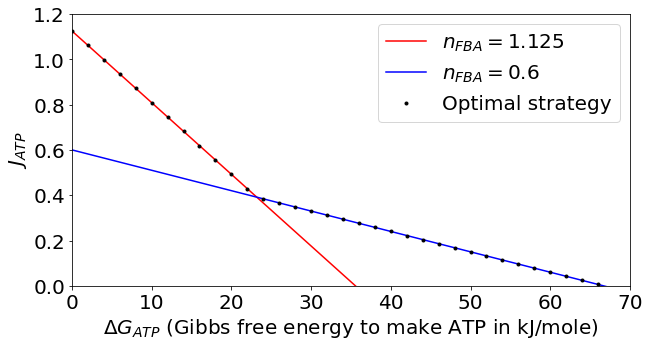

In [5]:
dG_atp = np.arange(0., 70., 0.2)
dG_atp_reduced = np.arange(0., 70., 2)

fig = plt.figure(figsize=(10,5))
plt.plot(dG_atp, 1.125*(1-1.125*dG_atp/40), 'r-', # n = 1.125
         dG_atp, 0.6*(1-0.6*dG_atp/40), 'b-', # n = 0.6
         dG_atp_reduced, np.maximum.reduce([0.6*(1-0.6*dG_atp_reduced/40),
                                  1.125*(1-1.125*dG_atp_reduced/40)]), 'k.') # the best yield: gear-shifting
plt.axis([0, 70, 0, 1.2])
plt.ylabel(r'$J_{ATP}$')
plt.xlabel(r'$\Delta G_{ATP}$ (Gibbs free energy to make ATP in kJ/mole)')
plt.legend([r'$n_{FBA} = 1.125$',r'$n_{FBA} = 0.6$','Optimal strategy'])
plt.savefig('../Figures/two_yield_values_one_optimum.pdf')
plt.show()

## Which stoichiometric yield is optimal for a given dG_ATP?
Plot max. J_ATP as function of dG_ATP for a large number of values of $n$ and then plot the value $n$ that maximizes J_ATP as function of dG_ATP.

For higher dG_ATP it is more optimal to switch to lower $n$ pathways.

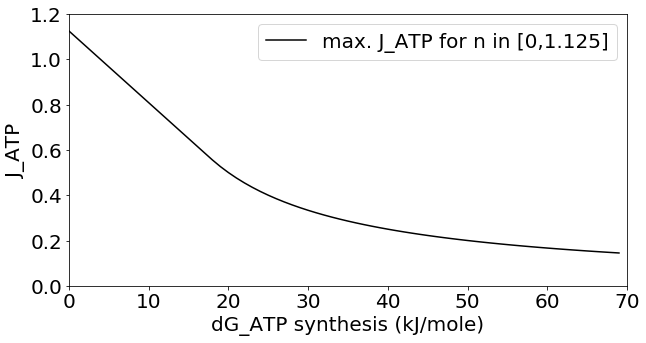

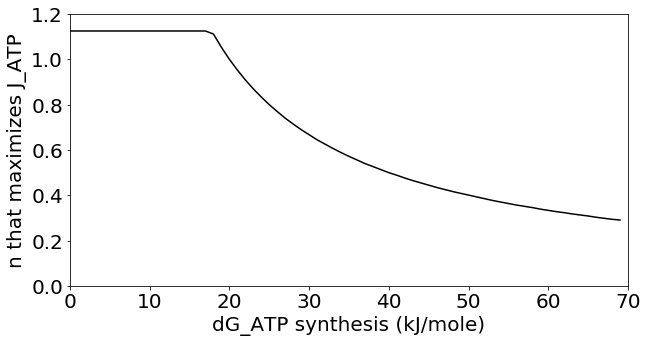

In [6]:
from scipy.optimize import fmin
def flux_compensated(x):
    n,Gp,Ga = x[:]
    return n * (1. - n * Gp/Ga)

result = {} # keys: Gp values, keys: lists of n_r values for various n

for i in range(1001):
    n = 1.125 * i/1000
    for j in range(70):
        y = flux_compensated([n,j,40])
        if j not in result:
            result[j] = []
        result[j].append(y)
        
max_result = []
max_n = []
for j in result:
    m = max(result[j])
    ind = result[j].index(m)
    max_result.append(m)
    max_n.append(1.125 * ind/1000)
    
    
t = np.arange(0,70)

fig = plt.figure(figsize=(10,5))
plt.plot(t, max_result, 'k-')
plt.axis([0, 70, 0, 1.2])
plt.ylabel('J_ATP')
plt.xlabel('dG_ATP synthesis (kJ/mole)')
plt.legend(['max. J_ATP for n in [0,1.125]'])
plt.savefig('../Figures/continuous_Jatp_vs_dGatp.pdf')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.plot(t, max_n, 'k-')
plt.axis([0, 70, 0, 1.2])
plt.ylabel('n that maximizes J_ATP')
plt.xlabel('dG_ATP synthesis (kJ/mole)')
plt.savefig('../Figures/continuous_nmax_vs_dGatp.pdf')
plt.show()
    

### Repeat the above only for values from Mondeel et al., 2016 Table 2 

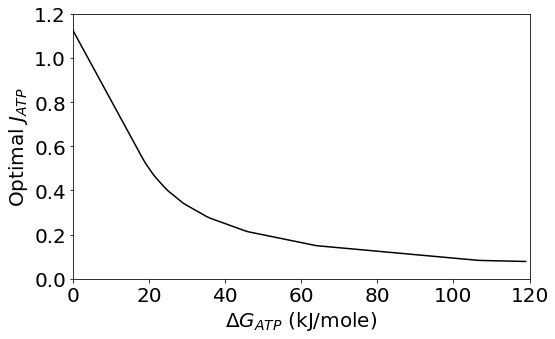

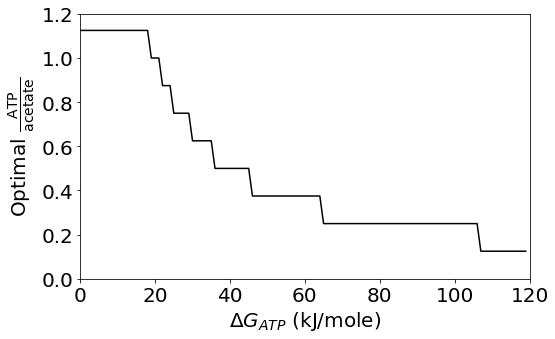

In [7]:
result = {} # keys: Gp values, keys: lists of n_r values for various n

n_table_values = [0., 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1., 1.125]
max_dG = 120

for i in n_table_values:
    n = i
    for j in range(max_dG):
        y = flux_compensated([n,j,40])
        if j not in result:
            result[j] = []
        result[j].append(y)
        
max_result = []
max_n = []
for j in result:
    m = max(result[j])
    ind = result[j].index(m)
    max_result.append(m)
    max_n.append(n_table_values[ind])
    
    
t = np.arange(0,max_dG)
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(8,5))
plt.plot(t, max_result, 'k-')
plt.axis([0, max_dG, 0, 1.2])
plt.ylabel(r'Optimal $J_{ATP}$')
plt.xlabel(r'$\Delta G_{ATP}$ (kJ/mole)')
plt.tight_layout()
plt.savefig('../Figures/tableValues_Jatp_vs_dGatp.pdf')
plt.show()

fig = plt.figure(figsize=(8,5))
plt.plot(t, max_n, 'k-')
plt.axis([0, max_dG, 0, 1.2])
plt.ylabel(r'Optimal $\frac{\mathrm{ATP}}{\mathrm{acetate}}$')
plt.xlabel(r'$\Delta G_{ATP}$ (kJ/mole)')
plt.tight_layout()
plt.savefig('../Figures/tableValues_nmax_vs_dGatp.pdf')
plt.show()